In [1]:
# imports
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import re
import seaborn as sns
%matplotlib inline

In [2]:
# dataset as df
data = pd.read_csv('AmesHousing.tsv', delimiter= '\t')

In [3]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## Feature engineering:

Here we will prepare and filter the features that will be used by out machine learning model.
The first thing we'll do is add two columns that describe the age a building was sold or remodeled. This should hopefully be much more useful for the model.

In [4]:
age_sold = data['Yr Sold'] - data['Year Built']
age_remod = data['Year Remod/Add'] - data['Year Built']

data['age_sold'] = age_sold
data['age_remod'] = age_remod

### transform_features:

This function's goal is to clean data it receives. It does this by:

1. Dropping all columns with more than a given ammount of NaN values (currently 5%)
3. Certain columns are dropped by name directly, as they don't contribute useful information or are otherwise not useful for machine learning. These are also columns that can leak the sale price without providing information about the building itself. They can be found in the list `drop_cols`
3. replacing the values in columns with between 0 & 5% NaN values with the mode for that column.



In [5]:
def transform_features(df):
    drop_cols = ['Year Built', 'Yr Sold', 'Year Remod/Add',
                 'Mo Sold', 'banana', 'Order', 'PID',
                 "Sale Condition", "Sale Type", 'Garage Cars']
    missing_vals = df.isnull().sum()/df.shape[0]
    high_na_cols = df.columns[missing_vals > 0.05]
    df = df.drop(columns = high_na_cols)
#     sale_cols = df.columns[df.columns.str.contains('sold', flags = re.I)]
#     df = df.drop(columns = sale_cols)
    
    # dropping columns by name
    for column in drop_cols:
        if column in df.columns:
            df = df.drop(columns = column)
        else:
            print('column {} not in dataframe'.format(column))

    missing_vals = df.isnull().sum()/df.shape[0]
    low_na_num = ((df[missing_vals[(missing_vals > 0) & (missing_vals < 0.05)].index])
                  .select_dtypes(include = ['int','float']).columns)
    if low_na_num.shape[0] > 0:
        df[low_na_num] = df[low_na_num].fillna(df[low_na_num].mode().to_dict(orient='records')[0])
        
    return df

### Select features:

This function selects the values we want to use for our machine learning model as features.

In [6]:
def select_features(df):
    numerical_df = df.select_dtypes(include = ['int','float'])
    corr_cols = numerical_df.columns[numerical_df.corr().SalePrice.abs() > 0.4]

    return data[numerical_df[corr_cols]]

### train_and_test:

This function trains and tests the model using the features we have pre-cleaned and selected.
The function:

1. divides our dataset into a training function and a test function
2. calls the select_features function to get cleaned data from the sets
3. instantiates, trains and tests a machine learning model using the linear regression model and the scikit learn module.It tests the accuracy of the model by calculating the root mean squared error when comparing the model's prediction of the `SalePrice` of the house to the value in the test set.

In [7]:
def train_and_test(df):
    # divide the data in a train and test set
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    # extract features to use and use only the numerical columns
    features = train
    num_cols = features.select_dtypes(include = ['float','int']).drop(columns = ['SalePrice'])
    
    # instantiating, training and testing the machine_learning model
    lr = LinearRegression()
    lr.fit(num_cols, train.SalePrice)
    predictions = lr.predict(test[num_cols.columns])
    rmse = mean_squared_error(test.SalePrice, predictions)**0.5
    return rmse

## Feature Selection:

Let's now go into feature selection:
We will first look at how strongly the different numerical columns correlate to each other and therefore are likely to contain redundant information. We will do this by plotting a heatmap of the correlation matrix.

column banana not in dataframe


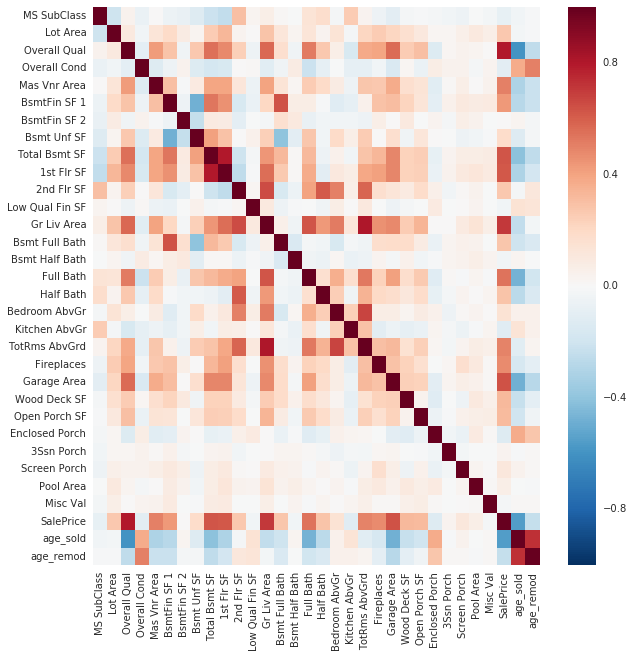

In [8]:
numerical_df = transform_features(data).select_dtypes(include = ['int','float'])

plt.figure(figsize = (10,10))
sns.heatmap(numerical_df.corr())

The graph above shows us one group of redundant information:
garage_cars and garage_area are redundant. We will drop cars and keep area, because it is more granular.
With the other correlations it is not entirely clear if the information is redundant or important. For example, of course the area of the basement is very closely related to that of the ground floor, since the ground floor is built on top of the basement, but they both contribute to the total area of the house. So if we dropped one of them, they would contribute less than the other, higher floors.

## Feature selection: Target column:

Let's now find out how strongly the different features correlate to our target column, to be able to judge which we should use.

In [9]:
corr_cols = numerical_df.columns[numerical_df.corr().SalePrice.abs() > 0.4]

In [10]:
numerical_df[corr_cols].head()

,Overall Qual,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,Fireplaces,Garage Area,SalePrice,age_sold
0,6,112.0,639.0,1080.0,1656,1656,1,7,2,528.0,215000,50
1,5,0.0,468.0,882.0,896,896,1,5,0,730.0,105000,49
2,6,108.0,923.0,1329.0,1329,1329,1,6,0,312.0,172000,52
3,7,0.0,1065.0,2110.0,2110,2110,2,8,2,522.0,244000,42
4,5,0.0,791.0,928.0,928,1629,2,6,1,482.0,189900,13


## Current functions:

In [11]:
def transform_features(df = data):
    drop_cols = ['Year Built', 'Yr Sold', 'Year Remod/Add',
                 'Mo Sold', 'banana', 'Order', 'PID',
                 "Sale Condition", "Sale Type", 'Garage Cars', 'Alley']
    missing_vals = df.isnull().sum()/df.shape[0]
    high_na_cols = df.columns[missing_vals > 0.05]
    df = df.drop(columns = high_na_cols)
#     sale_cols = df.columns[df.columns.str.contains('sold', flags = re.I)]
#     df = df.drop(columns = sale_cols)
    # dropping columns by name
    for column in drop_cols:
        if column in df.columns:
            df = df.drop(columns = column)
        else:
            print('column {} not in dataframe'.format(column))
    missing_vals = df.isnull().sum()/df.shape[0]
    low_na_num = ((df[missing_vals[(missing_vals > 0) & (missing_vals < 0.05)].index])
                  .select_dtypes(include = ['int','float']).columns)
    if low_na_num.shape[0] > 0:
        df[low_na_num] = df[low_na_num].fillna(df[low_na_num].mode().to_dict(orient='records')[0])
        
    return df

def select_features(df = transform_features()):
    numerical_df = df.select_dtypes(include = ['int','float'])
    corr_cols = numerical_df.columns[numerical_df.corr().SalePrice.abs() > 0.4]

    return numerical_df[corr_cols]

def train_and_test(df = select_features()):
    # divide the data in a train and test set
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    # extract features to use and use only the numerical columns
    features = train
    num_cols = features.select_dtypes(include = ['float','int']).drop(columns = ['SalePrice'])
    
    # instantiating, training and testing the machine_learning model
    lr = LinearRegression()
    lr.fit(num_cols, train.SalePrice)
    predictions = lr.predict(test[num_cols.columns])
    rmse = mean_squared_error(test.SalePrice, predictions)**0.5
    return rmse

column banana not in dataframe
column Alley not in dataframe


## Columns for categorization

Now we will find columns, that could benefit from being categorized and categorize them. For this we need nominal features. In our dataframe, these are:

In [12]:
nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]

We will reduce these to those nominal features, that have 10 or less unique values. These will be our categorization

In [13]:
cat_cols = []
for column in nominal_features:
    uniques = data[column].unique().shape[0]
    if uniques >= 10:
        cat_cols.append(column)

Let's explore our new columns and see how many nan values they have

In [14]:
data[cat_cols].isnull().sum()

PID             0
MS SubClass     0
Neighborhood    0
Exterior 1st    0
Exterior 2nd    0
Sale Type       0
dtype: int64

'Mas Vnr Type' has 23 nan values. We can replace those with 'none'.

In [15]:
data['Mas Vnr Type'].value_counts(dropna = False)

None       1752
BrkFace     880
Stone       249
BrkCmn       25
NaN          23
CBlock        1
Name: Mas Vnr Type, dtype: int64

'Garage Type':

In [16]:
data['Garage Type'].value_counts(dropna = False)

Attchd     1731
Detchd      782
BuiltIn     186
NaN         157
Basment      36
2Types       23
CarPort      15
Name: Garage Type, dtype: int64

We can see that this column has 157 nan values. This probably just means that those houses have no garages. So we can again replace them with 'none'

The other columns with nan values will be excluded by our functions because of the large ammount of NaN values

In [17]:
df = data.copy()

for column in ['Garage Type', 'Mas Vnr Type']:
    if column in df.columns:
        print(df[column].isnull().sum())
        df[column] = df[column].fillna('none')
        print(df[column].isnull().sum())

157
0
23
0


Now we will drop the columns, our functions will drop anyways

In [18]:
for column in ['Misc Feature', 'Alley']:
    if column in cat_cols:
        cat_cols.remove(column)

first we need to turn the columns into the categorical type, Then make dummy columns for their values. Finally we will drop the original columns.

In [19]:
for column in cat_cols:
    df[column] = df[column].astype('category')
df = pd.concat([df,pd.get_dummies(df.select_dtypes(include = ['category']))], axis = 1)
df = df.drop(cat_cols, axis = 1)
# dummies = pd.get_dummies(df[column].astype('category'),prefix = column)
#     df = pd.concat([df,dummies],axis = 1)
#     df = df.drop(columns = column)
# astype('category')

In [20]:
data.corr().SalePrice.abs().sort_values(ascending = False)

SalePrice          1.000000
Overall Qual       0.799262
Gr Liv Area        0.706780
Garage Cars        0.647877
Garage Area        0.640401
Total Bsmt SF      0.632280
1st Flr SF         0.621676
age_sold           0.558907
Year Built         0.558426
Full Bath          0.545604
Year Remod/Add     0.532974
Garage Yr Blt      0.526965
Mas Vnr Area       0.508285
TotRms AbvGrd      0.495474
Fireplaces         0.474558
BsmtFin SF 1       0.432914
Lot Frontage       0.357318
Wood Deck SF       0.327143
Open Porch SF      0.312951
Half Bath          0.285056
Bsmt Full Bath     0.276050
2nd Flr SF         0.269373
Lot Area           0.266549
PID                0.246521
age_remod          0.240168
Bsmt Unf SF        0.182855
Bedroom AbvGr      0.143913
Enclosed Porch     0.128787
Kitchen AbvGr      0.119814
Screen Porch       0.112151
Overall Cond       0.101697
MS SubClass        0.085092
Pool Area          0.068403
Low Qual Fin SF    0.037660
Bsmt Half Bath     0.035835
Mo Sold            0

We can now include this all in our `transform_features()` and `select_features()` functions:

In [21]:
def transform_features(df = data,un_thresh = 10, nan_thresh = 0.05):
    drop_cols = ['Year Built', 'Yr Sold', 'Year Remod/Add',
                 'Mo Sold', 'banana', 'Order', 'PID',
                 "Sale Condition", "Sale Type", 'Garage Cars', 'Alley']
    missing_vals = df.isnull().sum()/df.shape[0]
    high_na_cols = df.columns[missing_vals > nan_thresh]
    df = df.drop(columns = high_na_cols)
    # Turning the nominal columns into categorical dummies:
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    # making the column list for the categorization
    cat_cols = []
    for column in nominal_features:
        if column in df.columns:
            uniques = data[column].unique().shape[0]
            if uniques < un_thresh:
                cat_cols.append(column)
                
    # replacing the nan values in the two columns that have few
    for column in ['Garage Type', 'Mas Vnr Type']:
        if column in df.columns:
            df[column] = df[column].fillna('none')
        
    # finally making the dummy columns and concatenating them to df
    for column in cat_cols:
        df[column] = df[column].astype('category')
    df = pd.concat([df,pd.get_dummies(df.select_dtypes(include = ['category']))], axis = 1)
    df = df.drop(cat_cols, axis = 1)
    
    # dropping certain columns by name
    for column in drop_cols:
        if column in df.columns:
            df = df.drop(columns = column)
        else:
            print('column {} not in dataframe'.format(column))
    missing_vals = df.isnull().sum()/df.shape[0]
    low_na_num = ((df[missing_vals[(missing_vals > 0) & (missing_vals < 0.05)].index])
                  .select_dtypes(include = ['int','float']).columns)
    if low_na_num.shape[0] > 0:
        df[low_na_num] = df[low_na_num].fillna(df[low_na_num].mode().to_dict(orient='records')[0])
    print(df.shape)
    return df

def select_features(df = transform_features(),corr_thresh = 0.4):
    numerical_df = df.select_dtypes(include = ['int','float'])
    corr_cols = numerical_df.columns[numerical_df.corr().SalePrice.abs() > corr_thresh]

    return numerical_df[corr_cols]

def train_and_test(df = select_features()):
    # divide the data in a train and test set
    sp = df.SalePrice
    df.drop(columns = 'SalePrice',inplace = True)
    df = (df - df.min()) /(df.max() - df.min())
    df = pd.concat([df,sp], axis =1)
    train = df.iloc[:1460]
    test = df.iloc[1460:]
    
    # extract features to use and use only the numerical columns
    features = train
    num_cols = features.select_dtypes(include = ['float','int']).drop(columns = ['SalePrice'])
    
    # instantiating, training and testing the machine_learning model
    lr = LinearRegression()
    lr.fit(num_cols, train.SalePrice)
    predictions = lr.predict(test[num_cols.columns])
    rmse = mean_squared_error(test.SalePrice, predictions)**0.5
    return rmse

column banana not in dataframe
column Sale Condition not in dataframe
column Alley not in dataframe
(2930, 138)


In [22]:
train_and_test()

40838.476842105505

Now let's make a more refined model for testing our algorithm:
We will add a new parameter k:
* if k == 0, we will use the selection process, we have so far:
    1. splitting the dataframe at 1460
    2. training on the train set
    3. testing on the test set and calculating the rmse
* if k==1 we will do a cross validation:
    1. Shuffle the rows
    2. assign the first 1460 rows to a variable called `fold_one`
    3. assign the rest to `fold_two`
    4. train on `fold_one`, test on `fold_two`
    5. train on `fold_two`, test on `fold_one`
    6. calculate the average rmse
   

In [48]:
np.random.seed(1)
df = transform_features(data)
df = select_features(df)

#randomizing the dataset's rows
shuffled_index = np.random.permutation(df.shape[0])
df = df.iloc[shuffled_index].reset_index().drop('index', axis = 1)

# making the two training sets
fold_one = df.iloc[:1460].copy()
fold_two = df.iloc[1460:].copy()
fold_one_sp = fold_one.SalePrice.copy()
fold_one.drop(columns = 'SalePrice', inplace = True)
fold_two_sp = fold_two.SalePrice.copy()
fold_two.drop(columns = 'SalePrice', inplace = True)

#training models and calculating the rmses
lr = LinearRegression()

lr.fit(fold_one, fold_one_sp)
predicts_f_1 = lr.predict(fold_two)
rmse1 = mean_squared_error(fold_two_sp, predicts_f_1)**0.5

lr.fit(fold_two, fold_two_sp)
predicts_f_2 = lr.predict(fold_one)
rmse2 = mean_squared_error(fold_one_sp, predicts_f_2)**0.5
print((rmse1+rmse2)/2)

column banana not in dataframe
column Sale Condition not in dataframe
column Alley not in dataframe
(2930, 138)
35181.29274302897


let's add this functionality to `train_test()`:

In [49]:
def transform_features(df = data,un_thresh = 10, nan_thresh = 0.05):
    drop_cols = ['Year Built', 'Yr Sold', 'Year Remod/Add',
                 'Mo Sold', 'banana', 'Order', 'PID',
                 "Sale Condition", "Sale Type", 'Garage Cars', 'Alley']
    missing_vals = df.isnull().sum()/df.shape[0]
    high_na_cols = df.columns[missing_vals > nan_thresh]
    df = df.drop(columns = high_na_cols)
    # Turning the nominal columns into categorical dummies:
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    # making the column list for the categorization
    cat_cols = []
    for column in nominal_features:
        if column in df.columns:
            uniques = data[column].unique().shape[0]
            if uniques < un_thresh:
                cat_cols.append(column)
                
    # replacing the nan values in the two columns that have few
    for column in ['Garage Type', 'Mas Vnr Type']:
        if column in df.columns:
            df[column] = df[column].fillna('none')
        
    # finally making the dummy columns and concatenating them to df
    for column in cat_cols:
        df[column] = df[column].astype('category')
    df = pd.concat([df,pd.get_dummies(df.select_dtypes(include = ['category']))], axis = 1)
    df = df.drop(cat_cols, axis = 1)
    
    # dropping certain columns by name
    for column in drop_cols:
        if column in df.columns:
            df = df.drop(columns = column)
        else:
            print('column {} not in dataframe'.format(column))
    missing_vals = df.isnull().sum()/df.shape[0]
    low_na_num = ((df[missing_vals[(missing_vals > 0) & (missing_vals < 0.05)].index])
                  .select_dtypes(include = ['int','float']).columns)
    if low_na_num.shape[0] > 0:
        df[low_na_num] = df[low_na_num].fillna(df[low_na_num].mode().to_dict(orient='records')[0])
    print(df.shape)
    return df

def select_features(df = transform_features(),corr_thresh = 0.4):
    numerical_df = df.select_dtypes(include = ['int','float'])
    corr_cols = numerical_df.columns[numerical_df.corr().SalePrice.abs() > corr_thresh]

    return numerical_df[corr_cols]

def train_and_test(df = select_features(), k = 0):
    if k == 0:
        # divide the data in a train and test set
        sp = df.SalePrice
        df.drop(columns = 'SalePrice',inplace = True)
        df = (df - df.min()) /(df.max() - df.min())
        df = pd.concat([df,sp], axis =1)
        train = df.iloc[:1460]
        test = df.iloc[1460:]
    
        # extract features to use and use only the numerical columns
        features = train
        num_cols = features.select_dtypes(include = ['float','int']).drop(columns = ['SalePrice'])
    
        # instantiating, training and testing the machine_learning model
        lr = LinearRegression()
        lr.fit(num_cols, train.SalePrice)
        predictions = lr.predict(test[num_cols.columns])
        rmse = mean_squared_error(test.SalePrice, predictions)**0.5
        return rmse
    if k == 1:
        np.random.seed(1)

        #randomizing the dataset's rows
        shuffled_index = np.random.permutation(df.shape[0])
        df = df.iloc[shuffled_index].reset_index().drop('index', axis = 1)

        # making the two training sets
        fold_one = df.iloc[:1460].copy()
        fold_two = df.iloc[1460:].copy()
        fold_one_sp = fold_one.SalePrice.copy()
        fold_one.drop(columns = 'SalePrice', inplace = True)
        fold_two_sp = fold_two.SalePrice.copy()
        fold_two.drop(columns = 'SalePrice', inplace = True)

        #training models and calculating the rmses
        lr = LinearRegression()

        lr.fit(fold_one, fold_one_sp)
        predicts_f_1 = lr.predict(fold_two)
        rmse1 = mean_squared_error(fold_two_sp, predicts_f_1)**0.5

        lr.fit(fold_two, fold_two_sp)
        predicts_f_2 = lr.predict(fold_one)
        rmse2 = mean_squared_error(fold_one_sp, predicts_f_2)**0.5
        return (rmse1+rmse2)/2        

column banana not in dataframe
column Sale Condition not in dataframe
column Alley not in dataframe
(2930, 138)


In [50]:
train_and_test(k = 1)

35181.29274302897

In [51]:
train_and_test()

40838.476842105505